# Main goal: 
- Hani is looking for the final list of genes which are drug induced significantly methylated, expressed and stabilized. 

    ○ Venn diagram 

    ○ UpsetR 

=> table of these genes with all logFCs, pvalues and screening scores. 


In [184]:
# cp -v radar/result.all.txt hl60_delta_mtyl_table.txt

In [185]:
import pandas as pd 
import numpy as np
# Teated vs. non-treated 
comparisons = [
    # HL-60 meRIP-seq - logFC
    'meRIP-seq/hl60_delta_mtyl_table.txt' ,
    # HL-60 Ribo-seq - lnTE
    'Ribo-seq/hl60_delta_te_table.txt' ,
    # HL-60 RNA-seq 
    # RNA experssion - log2FC
    'RNA-seq/hl60-exp/hl60_delta_exp_table.txt',
    # RNA stability  - logFC
    'RNA-seq/hl60-stbl/hl60_delta_stbl_table.txt',
    ## 5 other AML cell lines RNA-seq
    # RNA experssion - log2FC
    'RNA-seq/other-exp/kg1_delta_exp_table.txt', 'RNA-seq/other-exp/molm14_delta_exp_table.txt',
    'RNA-seq/other-exp/ociaml2_delta_exp_table.txt', 'RNA-seq/other-exp/ociaml3_delta_exp_table.txt',
    'RNA-seq/other-exp/thp1_delta_exp_table.txt',
    # RNA stability - logFC
    'RNA-seq/other-stbl/kg1_delta_stbl_table.txt', 'RNA-seq/other-stbl/molm14_delta_stbl_table.txt',
    'RNA-seq/other-stbl/ociaml2_delta_stbl_table.txt', 'RNA-seq/other-stbl/ociaml3_delta_stbl_table.txt',
    'RNA-seq/other-stbl/thp1_delta_stbl_table.txt'
]


# extract cell line name experiment name 
names = [c.split('/')[-1].replace('.txt','').replace('_table','') for c in comparisons]
tables = [pd.read_csv(x, sep = '\t') for x in comparisons]
cells = [names[i].split('_')[0] for i,x in enumerate(comparisons)]
experiments = [names[i].replace(cells[i]+'_', '') for i,x in enumerate(comparisons)]

# read data into Pandas Data.Frames 
Data = dict(((c,{}) for c in cells))
for i,x in enumerate(comparisons): 
    cel = cells[i]
    exp = experiments[i]
    # read data and write into dictionary 
    Data [cel][exp] = tables[i]

Data['hl60']['delta_te'] = Data['hl60']['delta_te'][['gene_id','gene_name','Estimate_treatmentDRUG','fdr_Pr...z.._treatmentDRUG']]
Data['hl60']['delta_mtyl'] = Data['hl60']['delta_mtyl'][['ensembl','name','logFC','p_value']]
Data['hl60']['delta_mtyl'].columns = ['gene_id','gene_name','logFC','pval']

Let's include CRISPR screening scores 

In [218]:
def make_score_df(screen, score, rep='ave_Rep1_Rep2'):
    '''
    Make dataframe for given score from CRISPR screening Excel file 
    '''

    score_cols = [i for i,c in enumerate(screen.columns) if score in c]
    # extract screen informations from Excel file 
    screen_info = list(zip(
        score_cols,
        screen.iloc[0, score_cols].tolist(), 
        screen.iloc[1, score_cols].tolist(), 
        screen.columns[score_cols].tolist() 
    ))
    
    # select columns for given score
    cols = [c[0] for c in screen_info if c[1] == rep]
    # remove top 3 rows 
    df = screen.iloc[3:,cols]
    # set DataFrame column names from row 1
    df.columns = screen.iloc[1,cols].tolist()
    # select rows with ENST prefix 
    df = df.iloc[[i for i,g in enumerate(df.transcripts) if 'ENST' in str(g)],:].reset_index(drop=True)
    # add gene_name column
    gene_names = screen.iloc[3:,0]
    df.insert (0, "gene_name", [g for g,t in zip(gene_names,df.transcripts) if 'ENST' in str(t)])
    # only keep one transcript name
    df.transcripts = [g.split(',')[0] for g in df.transcripts]    
    # rename phenotype score column to the score name
    df.columns = [score + ' score' if x=='average phenotype of strongest 3' else x for x in df.columns]
    return df

In [219]:
screen = pd.read_excel('screen/CRISPRi_HL60_DAC_genetable_collapsed.xlsx')

Data['hl60']['rho'] = make_score_df(screen, 'rho')
Data['hl60']['gamma'] = make_score_df(screen, 'gamma')

# Intersectional genes 
Find top genes across all cell lines and high throughput experiments:

In [142]:
Top = {}

In [143]:
def find_top(
    df,
    value, value_thr, stat, stat_thr,
    n_line=None, drop_dup=False):
    
    # Select rows (genes) which has value >= value_thr & stat < stat_thr 
    if n_line==None:
        up = df.iloc[
            [i for i,l in enumerate(
                np.array([
                    np.array(df.loc[:,value] >= value_thr),
                    np.array(df.loc[:,stat] < stat_thr)]).all(axis=0)) if l == 1]
                ,:] 
        dn = df.iloc[
            [i for i,l in enumerate(
                np.array([
                    np.array(df.loc[:,value] <= -1*(value_thr)),
                    np.array(df.loc[:,stat] < stat_thr)]).all(axis=0)) if l == 1]
                ,:] 
        
    # found in more than n_line cell lines 
    else:
        up = df.iloc[
            [i for i,l in enumerate(
                np.array([
                    np.array(df.loc[:,value] >= value_thr).sum(axis=1) >= n_line,
                    np.array(df.loc[:,stat] < stat_thr).sum(axis=1) >= n_line]
                ).all(axis=0)) if l == 1]
                ,:]
        dn = df.iloc[
            [i for i,l in enumerate(
                np.array([
                    np.array(df.loc[:,value] <= -1*(value_thr)).sum(axis=1) >= n_line,
                    np.array(df.loc[:,stat] < stat_thr).sum(axis=1) >= n_line,]
                ).all(axis=0)) if l == 1]
                ,:] 
        
    if drop_dup==True:
        up = up.sort_values(stat).drop_duplicates(subset='gene_id', keep="last")
        dn = dn.sort_values(stat).drop_duplicates(subset='gene_id', keep="last")
    
    print ('up: ', up.shape)
    print ('down:', dn.shape)

    return up, dn


## Translational efficiency

In [206]:
Top['TE'] = {}

te_thr=0 # Estimate_treatmentDRUG
fdr_thr=0.2 # fdr_Pr...z.._treatmentDRUG

Top['TE']['threshold'] = [['te_thr',te_thr],['fdr_thr',fdr_thr]]

Top['TE']['up'], Top['TE']['down'] = find_top(
    Data['hl60']['delta_te'], 'Estimate_treatmentDRUG', te_thr, 'fdr_Pr...z.._treatmentDRUG', fdr_thr
)

up:  (157, 4)
down: (41, 4)


## $\Delta$RNA methylation

In [207]:
fc_thr = 2
pv_thr = 0.01

Top['Mtyl'] = {}

Top['Mtyl']['threshold'] = [['fc_thr',fc_thr],['pv_thr',pv_thr]]

Top['Mtyl']['up'], Top['Mtyl']['down'] = find_top(
    Data['hl60']['delta_mtyl'], 
    'logFC', fc_thr, 'pval', pv_thr, drop_dup=True)

up:  (1417, 4)
down: (820, 4)


## $\Delta$RNA expression 

Extract experssion data for 6 AML cell lines:

In [149]:
E1 = Data['hl60']['delta_exp']
E2 = Data['kg1']['delta_exp']
E3 = Data['molm14']['delta_exp']
E4 = Data['ociaml2']['delta_exp']
E5 = Data['ociaml3']['delta_exp']
E6 = Data['thp1']['delta_exp']

load R

In [150]:
%reload_ext rpy2.ipython

In [151]:
%%R 
suppressMessages(suppressWarnings(library (tidyverse)))

Merge into one DataFrame:

In [152]:
%%R -i E1,E2,E3,E4,E5,E6 -o exp_df

exp_ids = E1[,'gene_id']
exp_names = E1[,'gene_name']

Exp = list(
    # hl60
    E1 %>% dplyr::select('gene_id','log2FC_120h','pval_120h') %>% 
            rename(hl60.log2FC=log2FC_120h,
                   hl60.pval=pval_120h), 
    # kg1
    E2 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>%
            rename(kg1.log2FC=log2FoldChange,
                   kg1.pval=pvalue),  
    # molm14
    E3 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>%
            rename(molm14.log2FC=log2FoldChange,
                   molm14.pval=pvalue), 
    # ociaml2
    E4 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>%
            rename(ociaml2.log2FC=log2FoldChange,
                   ociaml2.pval=pvalue), 
    # ociaml3    
    E5 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>% 
            rename(ociaml3.log2FC=log2FoldChange,
                   ociaml3.pval=pvalue), 
    # thp1
    E6 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>%
            rename(thp1.log2FC=log2FoldChange,
                   thp1.pval=pvalue) 
)

for (i in 1:6){
    Exp[[i]] = Exp[[i]] %>% data.frame %>% remove_rownames %>% column_to_rownames('gene_id')
    Exp[[i]] = Exp[[i]][exp_ids,]
    
}

exp_df <- bind_cols(Exp) %>% add_column(gene_name=exp_names, .before=1)

In [153]:
exp_df.to_csv('delta_expression.txt')

In [156]:
Top['Exp'] = {}
fc_thr = 0.1
pv_thr = 0.1
Top['Exp']['threshold'] = [['fc_thr',fc_thr],['pv_thr',pv_thr]]

Top['Exp']['up'], Top['Exp']['down'] = find_top(
    exp_df, 
    [c for c in exp_df.columns if 'log2FC' in c], fc_thr,
    [c for c in exp_df.columns if 'pval' in c], pv_thr,
    n_line=4
)

up:  (414, 13)
down: (142, 13)


## $\Delta$RNA stability

In [157]:
S1 = Data['hl60']['delta_stbl']
S2 = Data['kg1']['delta_stbl']
S3 = Data['molm14']['delta_stbl']
S4 = Data['ociaml2']['delta_stbl']
S5 = Data['ociaml3']['delta_stbl']
S6 = Data['thp1']['delta_stbl']

Merge stability results from all AML cell lines into one DataFrame:

In [158]:
%%R -i S1,S2,S3,S4,S5,S6 -o stbl_df

stbl_ids = S1[,'ensembl_id']
stbl_names = S1[,'gene_name']

Stbl = list(
    # hl60
    S1 %>% dplyr::select('ensembl_id','logFC_120h','P.Value_120h') %>% 
            rename(hl60.log2FC=logFC_120h,
                   hl60.pval=P.Value_120h), 
    # kg1
    S2 %>% dplyr::select('ensembl_id','logFC','P.Value') %>%
            rename(kg1.log2FC=logFC,
                   kg1.pval=P.Value),  
    # molm14
    S3 %>% dplyr::select('ensembl_id','logFC','P.Value') %>%
            rename(molm14.log2FC=logFC,
                   molm14.pval=P.Value), 
    # ociaml2
    S4 %>% dplyr::select('ensembl_id','logFC','P.Value') %>%
            rename(ociaml2.log2FC=logFC,
                   ociaml2.pval=P.Value), 
    # ociaml3    
    S5 %>% dplyr::select('ensembl_id','logFC','P.Value') %>% 
            rename(ociaml3.log2FC=logFC,
                   ociaml3.pval=P.Value), 
    # thp1
    S6 %>% dplyr::select('ensembl_id','logFC','P.Value') %>%
            rename(thp1.log2FC=logFC,
                   thp1.pval=P.Value) 
)

for (i in 1:6){
    Stbl[[i]] = Stbl[[i]] %>% data.frame %>% remove_rownames %>% column_to_rownames('ensembl_id')
    Stbl[[i]] = Stbl[[i]][stbl_ids,]
    
}

stbl_df <- bind_cols(Stbl) %>% add_column(gene_name=stbl_names, .before=1)

In [159]:
exp_df.to_csv('delta_stability.txt')

In [209]:
Top['Stbl'] = {}

fc_thr = 0
pv_thr = 0.5

Top['Stbl']['threshold'] = [['fc_thr',fc_thr],['pv_thr',pv_thr]]

Top['Stbl']['up'], Top['Stbl']['down'] = find_top(
    stbl_df, 
    [c for c in stbl_df.columns if 'log2FC' in c], fc_thr,
    [c for c in stbl_df.columns if 'pval' in c], pv_thr,
    n_line=4
)

up:  (459, 13)
down: (502, 13)


## $\Delta$ Phenotype 

In [224]:
Top['Rho'] = {}

sc_thr = 0.05
pv_thr = 0.5

Top['Rho']['threshold'] = [['sc_thr',sc_thr],['pv_thr',pv_thr]]
Top['Rho']['up'], Top['Rho']['down']  = find_top(
    Data['hl60']['rho'], 
    'rho score', sc_thr,'Mann-Whitney p-value', pv_thr)

up:  (216, 6)
down: (231, 6)


# Plots

In [166]:
%reload_ext rpy2.ipython

In [167]:
%%R 
suppressMessages(suppressWarnings(library (UpSetR)))
suppressMessages(suppressWarnings(library (gplots)))
suppressMessages(suppressWarnings(library (patchwork)))

### Intersection of all genes across different datasets

In [225]:
M = list(set(Data['hl60']['delta_mtyl'].gene_name.tolist()))
T = list(set(Data['hl60']['delta_te'].gene_name.tolist()))
R = list(set(Data['hl60']['rho'].gene_name.tolist()))
S = list(set(stbl_df.gene_name.tolist()))
E = list(set(exp_df.gene_name.tolist()))

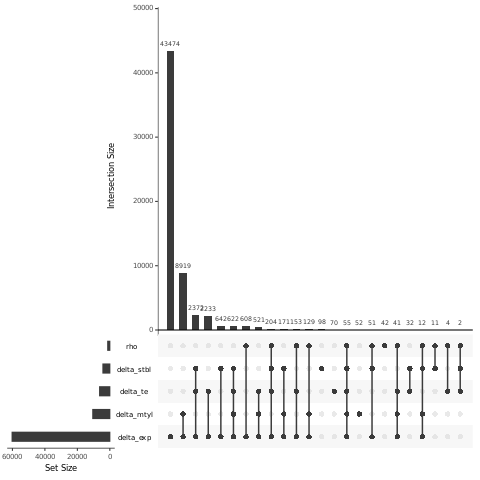

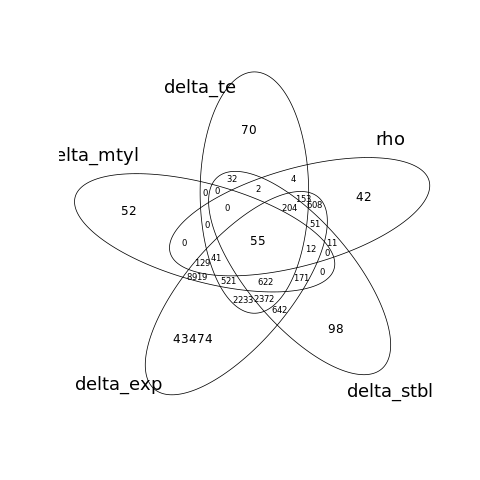

In [245]:
%%R -i M,T,R,S,E -o A

Vecs <- list(

    delta_mtyl = unlist(M),
    delta_te = unlist(T),
    rho = unlist(R),
    delta_stbl = unlist(S),
    delta_exp = unlist(E)
)

A = intersect_plot(Vecs)

### Up-regulated genes 

In [227]:
Exp_up = Top['Exp']['up'].gene_name.tolist()
Stbl_up = Top['Stbl']['up'].gene_name.tolist()
TE_up = Top['TE']['up'].gene_name.tolist()
Rho_up = Top['Rho']['up'].index.tolist()
Hyper_m6A = Top['Mtyl']['up'].gene_name.tolist()

In [228]:
%%R 
intersect_plot <- function(Vecs){
    intersection <- Reduce(intersect,Vecs)
    SET = upset(fromList(Vecs), order.by = "freq")
    print (SET)
    
    VEN = venn (Vecs)
    
    return(intersection)
}

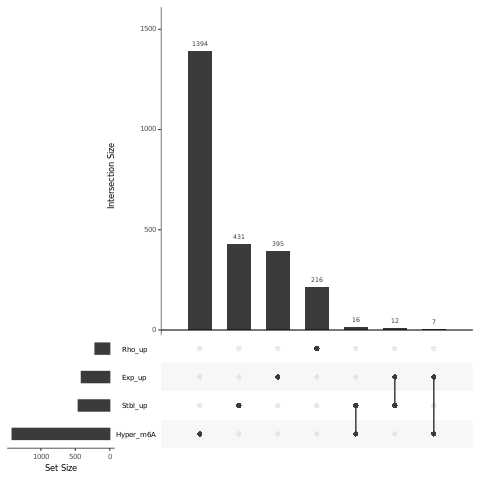

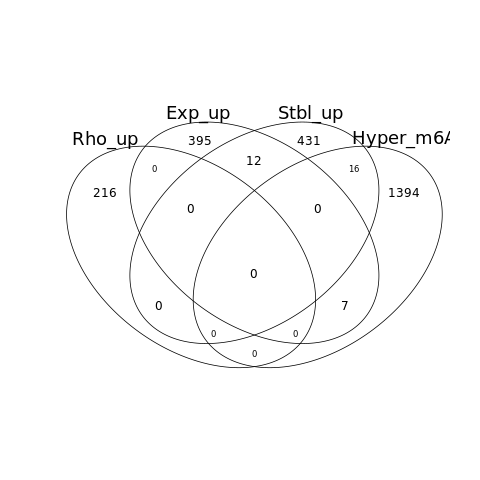

In [236]:
%%R -i Exp_up,Stbl_up,TE_up,Rho_up,Hyper_m6A
Vecs <- list(
    Rho_up=unlist(Rho_up), 
#     TE_up=unlist(TE_up), 
    Exp_up=unlist(Exp_up), 
    Stbl_up=unlist(Stbl_up), Hyper_m6A=unlist(Hyper_m6A)
)

up = intersect_plot(Vecs)

### Down regulated genes 

In [230]:
Exp_down = Top['Exp']['down'].gene_name.tolist()
Stbl_down = Top['Stbl']['down'].gene_name.tolist()
TE_down = Top['TE']['down'].gene_name.tolist()
Rho_down = Top['Rho']['down'].index.tolist()
Hypo_m6A = Top['Mtyl']['down'].gene_name.tolist()

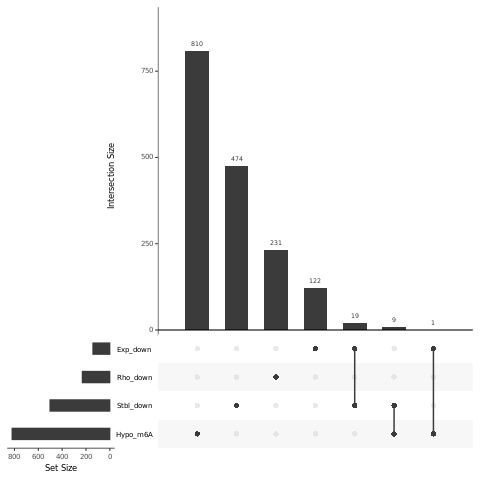

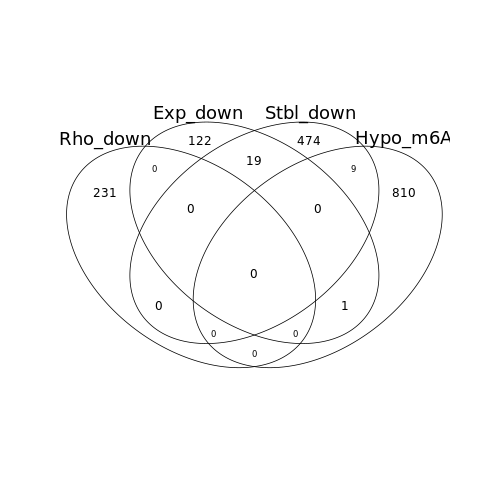

In [235]:
%%R -i Exp_down,Stbl_down,TE_down,Rho_down,Hypo_m6A
Vecs <- list(
    Rho_down=unlist(Rho_down), 
#     TE_down=unlist(TE_down), 
    Exp_down=unlist(Exp_down), 
    Stbl_down=unlist(Stbl_down), Hypo_m6A=unlist(Hypo_m6A)
)
dn = intersect_plot(Vecs)

# Venn diagram 

- https://python-graph-gallery.com/172-custom-venn-diagram/
- https://stackoverflow.com/questions/19841535/python-matplotlib-venn-diagram
- https://towardsdatascience.com/how-to-create-and-customize-venn-diagrams-in-python-263555527305


- https://anaconda.org/conda-forge/r-venn
- https://pypi.org/project/venn/

In [54]:
# # Import the library
# import matplotlib.pyplot as plt
# import numpy as np
# from itertools import combinations
# from matplotlib_venn import venn3

# def venn_diagram(a, b, c, labels=['A', 'B', 'C']):
    
#     a = list(set(a))
#     b = list(set(b))
#     c = list(set(c))
    
#     only_a = len( [x for x in a if x not in b+c] )
#     only_b = len( [x for x in b if x not in a+c] )
#     only_c = len( [x for x in c if x not in a+b] )

#     a_b = len(np.intersect1d(a, b))
#     a_c = len(np.intersect1d(a, c))
#     b_c = len(np.intersect1d(b, c))
    
#     a_b_c = len([ x for x in a if (x in b) and (x in c)])
    
#     venn3(subsets=(only_a, only_b, a_b, only_c, a_c, b_c, a_b_c), set_labels=labels)    
    
# def iter_venn(datasets, names):
#     # unique permutations on the number of given datasets 
#     iterations = list(combinations(list(range(len(datasets))), 3))
#     # draw unique venn_diagrams
#     for i,iteration in enumerate(iterations):
#         p = plt.figure(i)
#         a,b,c=[datasets[n] for n in iteration]
#         venn_diagram(a,b,c,labels=[names[n] for n in iteration]
#         )
#         p.show()    

In [239]:
Top.keys()

dict_keys(['TE', 'Mtyl', 'Exp', 'Stbl', 'Rho'])

# Final merged table

In [278]:
def get_intersect_df(df,k=None,A=A):
    if k is not None: 
        df = df[k]
    out = df.iloc[[i for i, g in enumerate (df.gene_name) if g in list(A)],]
    print (out.shape)
    return out

In [340]:
E = get_intersect_df(exp_df)
S = get_intersect_df(stbl_df)
M = get_intersect_df(Data['hl60'],'delta_mtyl')
T = get_intersect_df(Data['hl60'],'delta_te')
R = get_intersect_df(Data['hl60'],'rho')
G = get_intersect_df(Data['hl60'],'gamma')

(55, 13)
(55, 13)
(195, 4)
(55, 4)
(55, 6)
(55, 6)


In [341]:
final = pd.DataFrame(index=A)

final = pd.concat([
    final,
    # Expression
    E.reset_index().set_index('gene_name').iloc[:,range(1,13)].add_prefix('Exp.'),
    # Stability 
    S.reset_index().set_index('gene_name').iloc[:,range(1,13)].add_prefix('Stbl.'),
    # Translational Efficiency 
    T.reset_index().set_index('gene_name').iloc[:,[2,3]].add_prefix('TE.'),
    # CRISPR Screen Rho score
    R.reset_index().set_index('gene_name').iloc[:,[2,3]].add_prefix('Rho.'),
    # CRISPR Screen Gamma score
    G.reset_index().set_index('gene_name').iloc[:,[2,3]].add_prefix('Gamma.')
    
],axis=1)
    
final

,Exp.hl60.log2FC,Exp.hl60.pval,Exp.kg1.log2FC,Exp.kg1.pval,Exp.molm14.log2FC,Exp.molm14.pval,Exp.ociaml2.log2FC,Exp.ociaml2.pval,Exp.ociaml3.log2FC,Exp.ociaml3.pval,...,Stbl.ociaml3.log2FC,Stbl.ociaml3.pval,Stbl.thp1.log2FC,Stbl.thp1.pval,TE.Estimate_treatmentDRUG,TE.fdr_Pr...z.._treatmentDRUG,Rho.Mann-Whitney p-value,Rho.rho score,Gamma.Mann-Whitney p-value,Gamma.gamma score
ARID4B,1.873844,5.459174e-05,0.005348,0.971224,-0.121435,0.488989,-0.078033,0.630979,-0.131866,0.653566,...,0.149904,0.377735,-0.062338,0.440974,0.518204,0.489329,0.214181,-0.0414089,0.405668,-0.0120196
ANP32E,0.250062,2.968740e-01,0.116181,0.423428,-0.079635,0.505202,0.036525,0.800205,0.154492,0.487919,...,NaN,NaN,NaN,NaN,0.225975,0.625876,0.125011,-0.144616,0.336865,0.0150445
AZI2,-0.612527,6.972256e-04,-0.262278,0.499773,0.302658,0.677968,-0.599980,0.148433,0.762733,0.033566,...,0.075077,0.493708,0.066630,0.434478,0.255192,0.844812,0.134146,-0.0598634,0.589111,0.0094135
ANO7,2.672748,1.205133e-03,-0.042308,0.965930,2.848767,0.077467,-0.695336,0.314981,0.648215,0.528424,...,NaN,NaN,NaN,NaN,-0.195651,0.916031,0.603901,-0.0181305,0.258974,0.0140766
ATF2,-0.057344,8.508722e-01,0.066061,0.670792,0.076246,0.660530,-0.057659,0.777333,0.138463,0.541099,...,0.098109,0.399246,0.074784,0.413771,0.120818,0.927907,0.835935,-0.0403436,0.198064,0.0536902
ACTR3,0.159599,4.664222e-01,0.183542,0.305851,-0.022723,0.892373,0.110994,0.385908,-0.065198,0.691402,...,-0.102337,0.472939,0.189022,0.104831,0.004641,0.991587,0.769794,-0.0298932,0.407562,-0.00954081
ACBD6,0.512239,7.383949e-03,-0.300630,0.142487,-0.211268,0.294277,-0.051321,0.778702,-0.060161,0.794766,...,-0.048552,0.688030,-0.212361,0.233372,-0.256855,0.848798,0.00685239,0.101192,0.60013,-0.0110265
AGPS,0.468090,1.066561e-03,0.070446,0.702448,-0.157907,0.485176,0.119554,0.565173,0.351679,0.211768,...,0.260888,0.039059,0.129148,0.099255,0.309727,0.425615,0.410578,0.0548176,0.37744,0.0256336
ALG6,-0.414119,1.243118e-02,-0.242993,0.267770,-0.004601,0.987896,-0.009568,0.969577,-0.009439,0.979929,...,NaN,NaN,NaN,NaN,0.117216,0.945448,0.0770359,0.0736598,0.798408,-0.00976646
AUP1,1.131273,1.586873e-07,-0.127143,0.378415,0.088428,0.644867,-0.173756,0.310312,0.010523,0.960622,...,NaN,NaN,NaN,NaN,0.042842,0.962380,0.217322,0.0547684,0.403308,-0.0121778


In [265]:
%%R 
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/limma/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] patchwork_1.1.0 gplots_3.1.1    UpSetR_1.4.0    forcats_0.5.0  
 [5] stringr_1.4.0   dplyr_1.0.1     purrr_0.3.4     readr_1.3.1    
 [9] tidyr_1.1.1     tibble_3.0.3    ggplot2_3.3.2   tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] gtools_3.8.2       tidyselec